In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import json
import setigen as stg
import blscint as bls
import blimpy as bl
import pandas as pd
import numpy as np
from astropy.time import Time
from astropy.stats import sigma_clip
import astropy.units as u


prefix_template = '/mnt_blpd2/datax/PKSUWL/blcxx/PKSUWL'

In [2]:
meta = pd.read_csv('first_11_meta_info.csv', sep=';')
meta['indexes'] = meta['indexes'].str.strip()
meta.head()

,lookalike,node,direction,indexes
0,blc1,blc03,1,"[2,4,7,9,15]"
1,dr_-0.03_freq_933.342681,blc02,-1,"[2,3,4,7,8,9,10,11,12,13,14,15,16]"
2,dr_-0.04_freq_1200.011914,blc04,-1,"[1,2,3,4,5,7,8,9,11,12,13,14,15,16]"
3,dr_-0.04_freq_1312.585393,blc05,-1,"[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]"
4,dr_-0.04_freq_1333.346684,blc05,-1,"[2,3,4,5,7,8,9,10,11,12,13,14,15,16]"


In [3]:
drifts = pd.read_csv('first_11_drift_rates.csv', sep=';')
drifts.head()

,panel_id,filename,blc1,dr_-0.03_freq_933.342681,dr_-0.04_freq_1200.011914,dr_-0.04_freq_1312.585393,dr_-0.04_freq_1333.346684,dr_-0.04_freq_1350.008112,dr_-0.04_freq_1365.298917,dr_-0.04_freq_1398.598805,dr_-0.04_freq_1431.898859,dr_-0.04_freq_1485.008851,dr_-0.04_freq_1498.498799
0,0,blcxx_1421-490_S_2019-04-29T12:39:50.000.fil,NaN,NaN,NaN,-0.050000,NaN,0.042705,NaN,NaN,NaN,0.028557,NaN
1,1,blcxx_1421-490_R_2019-04-29T12:46:00.000.fil,NaN,NaN,-0.050000,-0.041303,NaN,0.020681,NaN,NaN,NaN,0.016333,NaN
2,2,blcxx_ProxCen_S_2019-04-29T13:02:35.000.fil,0.031202,-0.023627,-0.031904,-0.033587,-0.036673,0.029800,0.034569,0.033166,0.035571,0.032365,0.036774
3,3,blcxx_1421-490_S_2019-04-29T13:34:59.000.fil,NaN,-0.030220,-0.022645,-0.013246,-0.037796,0.037936,0.037936,NaN,NaN,0.045591,0.042786
4,4,blcxx_ProxCen_S_2019-04-29T13:47:46.000.fil,0.030361,-0.024048,-0.028818,-0.027415,-0.031343,0.023627,0.032605,0.034168,0.034569,0.031162,0.036573


In [4]:
centers = pd.read_csv('first_11_start_frequencies.csv', sep=';')
centers.head()

,panel_id,filename,blc1,dr_-0.03_freq_933.342681,dr_-0.04_freq_1200.011914,dr_-0.04_freq_1312.585393,dr_-0.04_freq_1333.346684,dr_-0.04_freq_1350.008112,dr_-0.04_freq_1365.298917,dr_-0.04_freq_1398.598805,dr_-0.04_freq_1431.898859,dr_-0.04_freq_1485.008851,dr_-0.04_freq_1498.498799
0,0,blcxx_1421-490_S_2019-04-29T12:39:50.000.fil,NaN,NaN,NaN,1312.586403,NaN,1350.008980,NaN,NaN,NaN,1485.009880,NaN
1,1,blcxx_1421-490_R_2019-04-29T12:46:00.000.fil,NaN,NaN,1200.013012,1312.586388,NaN,1350.008995,NaN,NaN,NaN,1485.009895,NaN
2,2,blcxx_ProxCen_S_2019-04-29T13:02:35.000.fil,982.002392,933.343426,1200.012978,1312.586357,1333.347755,1350.009026,1365.299881,1398.599880,1431.899876,1485.009930,1498.499870
3,3,blcxx_1421-490_S_2019-04-29T13:34:59.000.fil,NaN,933.343384,1200.012920,1312.586296,1333.347691,1350.009083,1365.299946,NaN,NaN,1485.009991,1498.499939
4,4,blcxx_ProxCen_S_2019-04-29T13:47:46.000.fil,982.002472,933.343369,1200.012901,1312.586281,1333.347668,1350.009106,1365.299973,1398.599972,1431.899971,1485.010014,1498.499969


### Using list instead

In [41]:
all_y = []
for i, meta_row in meta.iterrows():
    all_y.append({})
    all_y[-1]['name'] = meta_row['lookalike']
    all_y[-1]['signal'] = []
    
    idx = json.loads(meta_row['indexes'])
    for j in range(len(drifts)):
        all_y[-1]['signal'].append({})
        
        filename = drifts['filename'].loc[j]
        full_path = f'{prefix_template}/{filename}'.replace('blcxx', 
                                                            meta_row['node'])
        
        drift_rate = drifts[meta_row['lookalike']].loc[j]
        center_freq = centers[meta_row['lookalike']].loc[j]
        if pd.isnull(drift_rate):
            all_y[-1]['signal'][-1]['scaled_ts'] = None
            all_y[-1]['signal'][-1]['drift_rate'] = None
            all_y[-1]['signal'][-1]['center_freq'] = None
        else:
            frame = bls.centered_frame(fn=full_path,
                                       drift_rate=drift_rate,
                                       center_freq=center_freq,
                                       fchans=256)
            frame = stg.dedrift(frame, drift_rate=drift_rate)
            l, r, _ = bls.threshold_bounds(frame.integrate())
            n_frame = bls.t_norm_frame(frame)
            tr_frame = n_frame.get_slice(l, r)
            tr_y = tr_frame.integrate('f', mode='sum')
#             tr_y /= tr_y.mean()
            # normalize tr_y by noise levels
            tr_y /= np.std(sigma_clip(tr_frame.get_data()))
        
            all_y[-1]['signal'][-1]['scaled_ts'] = tr_y
            all_y[-1]['signal'][-1]['drift_rate'] = drift_rate
            all_y[-1]['signal'][-1]['center_freq'] = center_freq
len(all_y)

11

In [38]:
len(all_y[0]['signal'])

17

In [43]:
len(drifts)

17

### Compute frame.ts for use in estimation
Use unix time for convenience; can always scale back to first value as long as we track it!

In [24]:
ts_list = []
for j in range(len(all_y[0]['signal'])):
    filename = drifts['filename'].loc[j]
    # Just use blc1 data to get times
    full_path = f'{prefix_template}/{filename}'.replace('blcxx', 
                                                        meta.loc[0]['node'])

    container = bl.Waterfall(full_path, load_data=False).container
    tchans = container.file_shape[0]
    dt = container.header['tsamp']
    tstart = container.header['tstart']
    t = Time(tstart, format='mjd')
    x = np.linspace(0, tchans * dt, tchans, endpoint=False) + t.unix
    x = Time(x, format='unix').mjd
    ts_list.append(x)
ts = np.concatenate(ts_list)
len(ts_list), len(ts)

(17, 926)

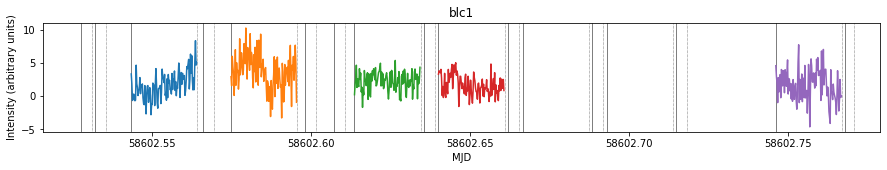

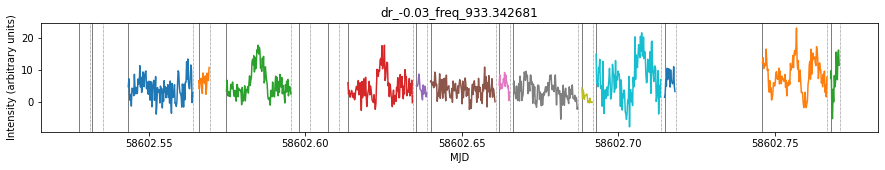

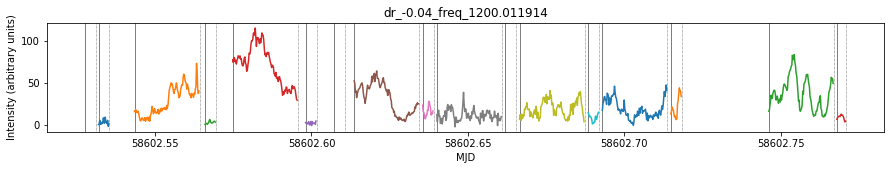

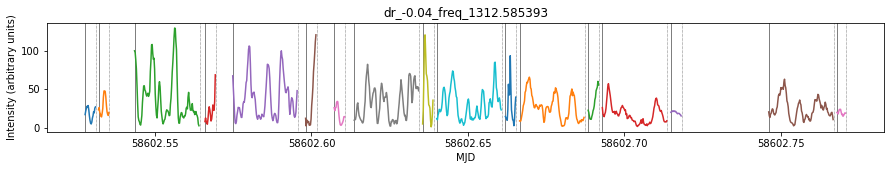

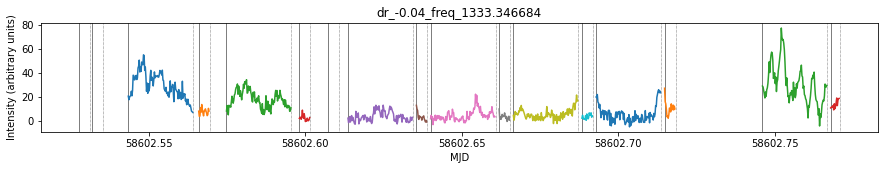

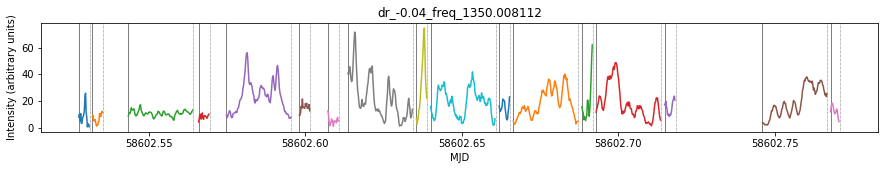

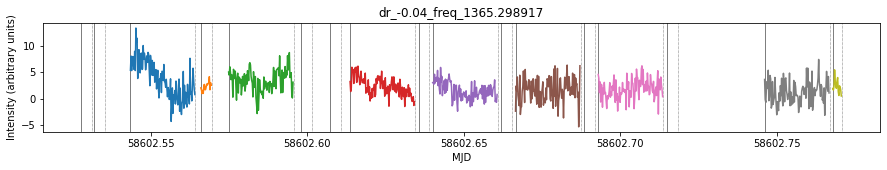

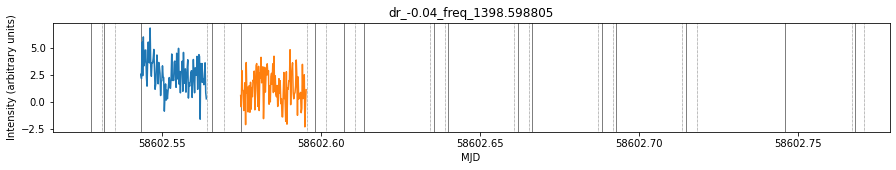

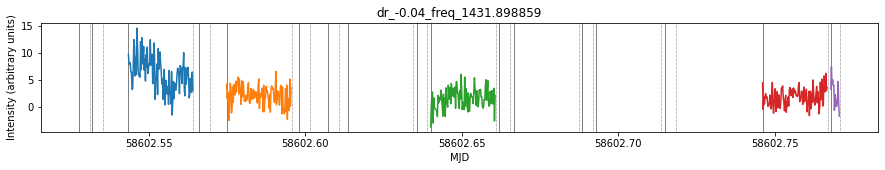

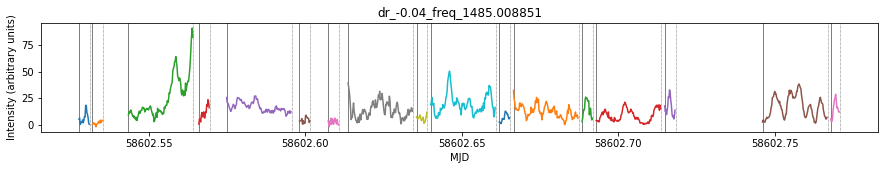

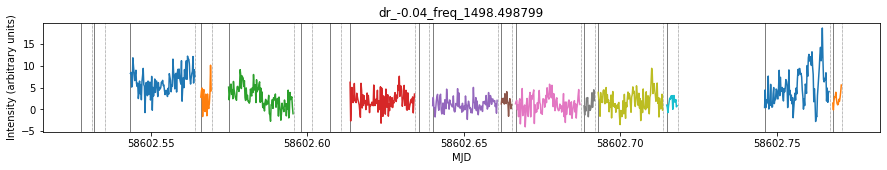

In [42]:
for i in range(len(all_y)):
    plt.figure(figsize=(15, 2))

    for j in range(len(all_y[0]['signal'])):
        x = ts_list[j]
        plt.axvline(x[0], ls='-', c='k', lw='0.5')
        plt.axvline(Time(Time(x[-1], format='mjd').unix + dt, format='unix').mjd, ls=':', c='k', lw='0.5')
    #     plt.axvline(x[-1]+dt*u.s, ls='--', c='k')
        y = all_y[i]['signal'][j]['scaled_ts']
        if y is not None:
            plt.plot(x, y)

    plt.ylabel('Intensity (arbitrary units)')
    plt.xlabel('MJD')
    plt.title(all_y[i]['name'])
    plt.show()

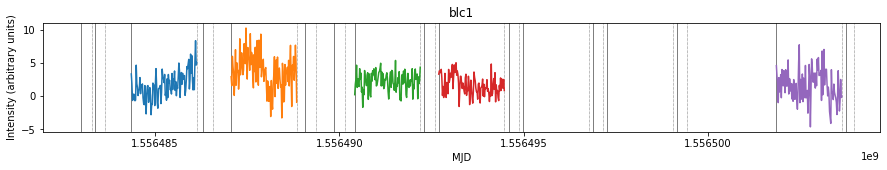

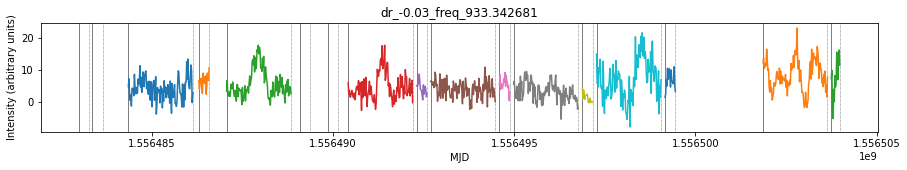

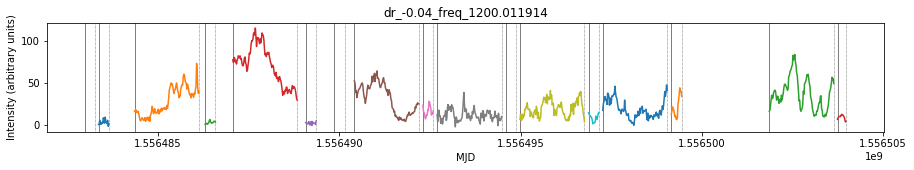

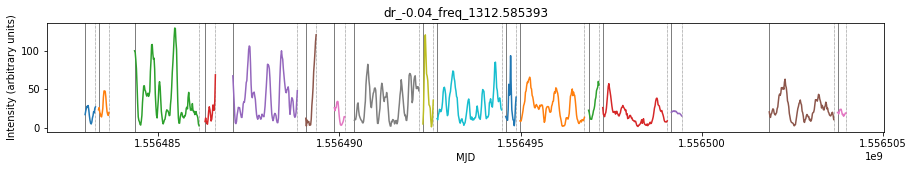

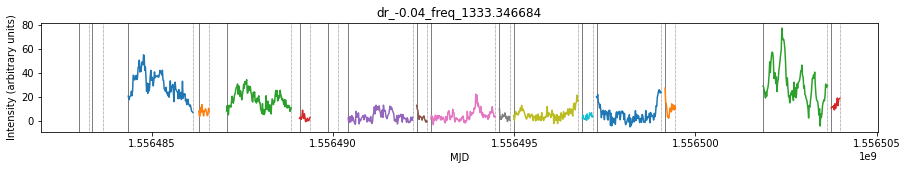

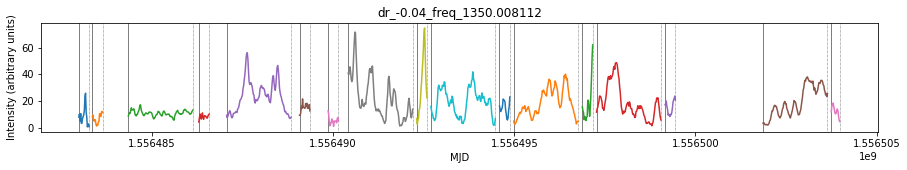

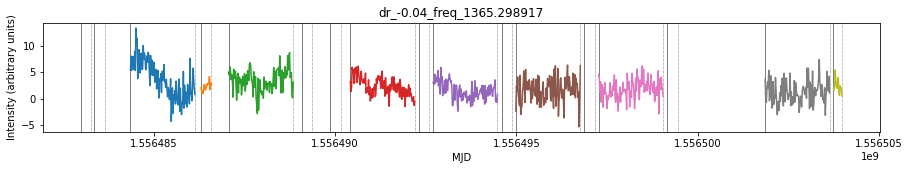

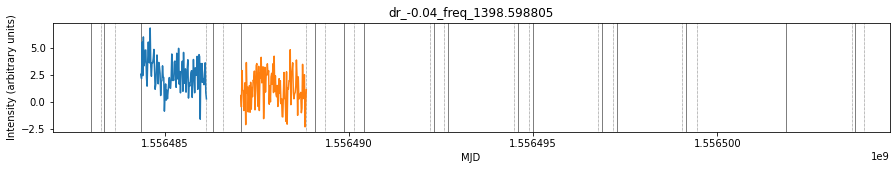

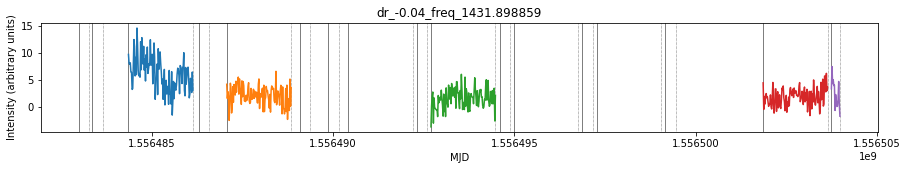

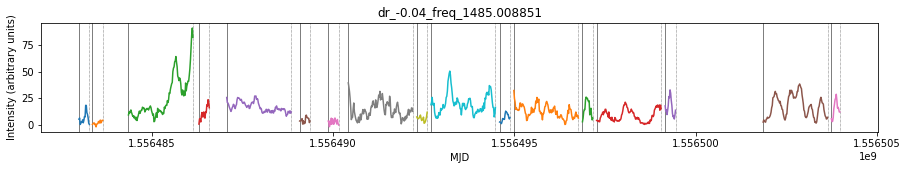

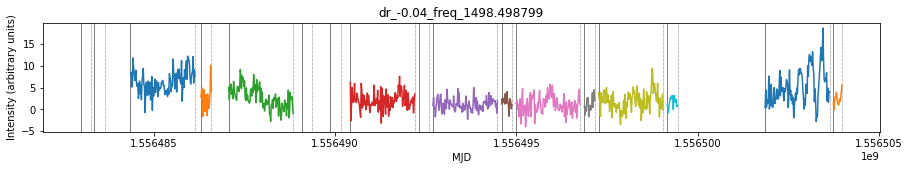

In [5]:
import extract_signals as es

all_y = es.all_time_series()
ts_info = es.get_ts_info()

for i in range(len(all_y)):
    plt.figure(figsize=(15, 2))

    for j in range(len(all_y[0]['signal'])):
        x = ts_info['ts_list'][j]
        plt.axvline(x[0], ls='-', c='k', lw='0.5')
        plt.axvline(Time(Time(x[-1], format='mjd').unix + ts_info['dt'], format='unix').mjd, ls=':', c='k', lw='0.5')
    #     plt.axvline(x[-1]+dt*u.s, ls='--', c='k')
        y = all_y[i]['signal'][j]['scaled_ts']
        if y is not None:
            plt.plot(x, y)

    plt.ylabel('Intensity (arbitrary units)')
    plt.xlabel('MJD')
    plt.title(all_y[i]['name'])
    plt.show()

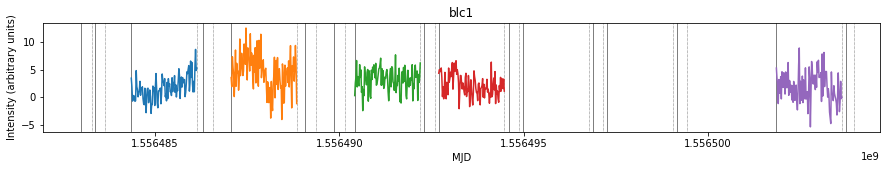

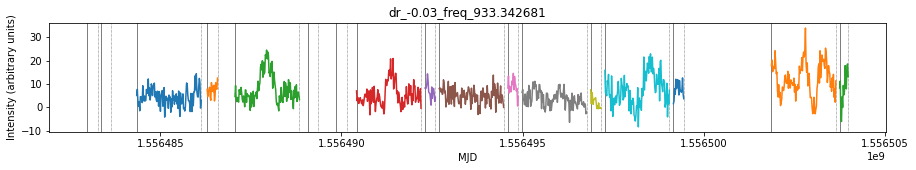

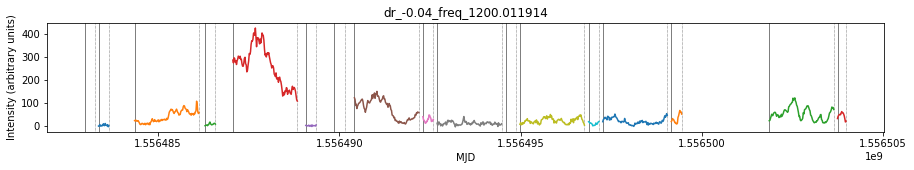

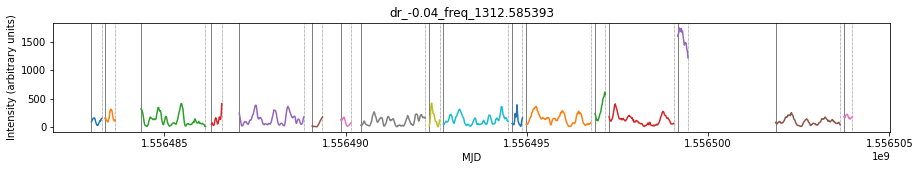

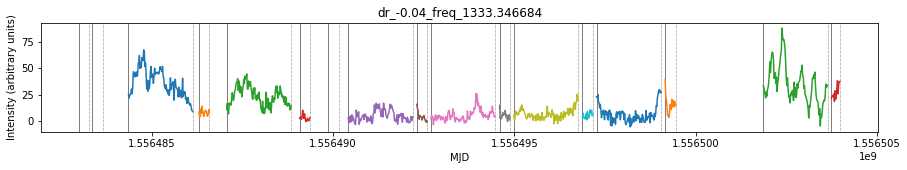

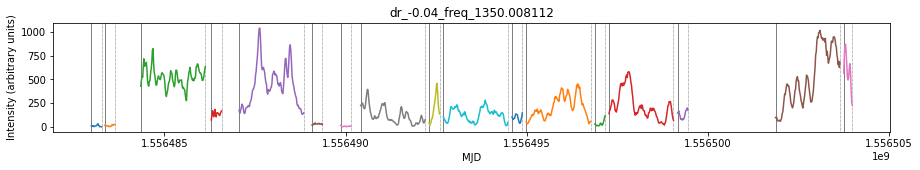

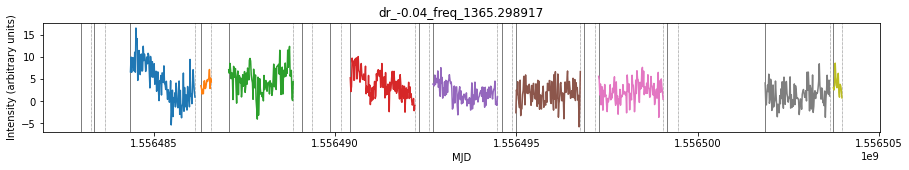

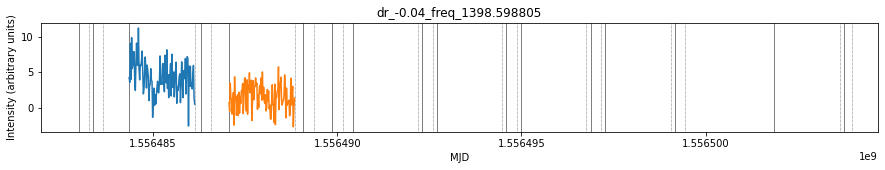

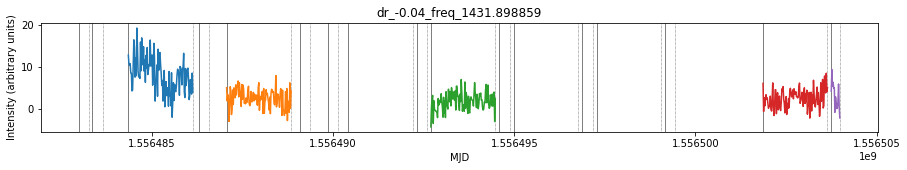

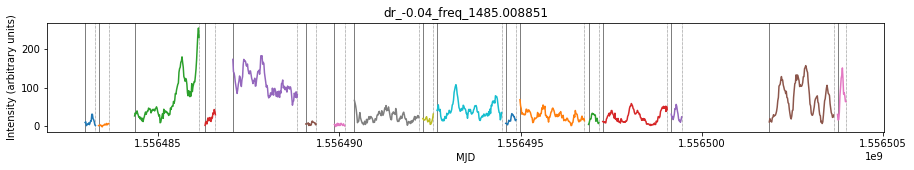

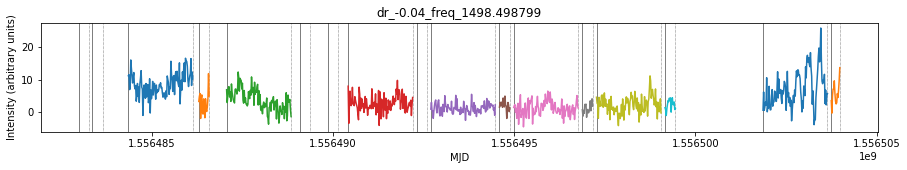

In [41]:
import extract_signals as es

all_y = es.all_time_series()
ts_info = es.get_ts_info()

for i in range(len(all_y)):
    plt.figure(figsize=(15, 2))

    for j in range(len(all_y[0]['signal'])):
        x = ts_info['ts_list'][j]
        plt.axvline(x[0], ls='-', c='k', lw='0.5')
        plt.axvline(Time(Time(x[-1], format='mjd').unix + ts_info['dt'], format='unix').mjd, ls=':', c='k', lw='0.5')
    #     plt.axvline(x[-1]+dt*u.s, ls='--', c='k')
        y = all_y[i]['signal'][j]['scaled_ts']
        if y is not None:
            plt.plot(x, y)

    plt.ylabel('Intensity (arbitrary units)')
    plt.xlabel('MJD')
    plt.title(all_y[i]['name'])
    plt.show()

In [6]:
ts_info.keys()

dict_keys(['tstart', 'dt', 'ts_list'])

In [42]:
np.save('ts_info.npy', ts_info)
np.save('intensity_data.npy', all_y)

In [19]:
all_y[0]['signal'][2]['center_freq']

982.002391815186

In [26]:
x = np.load('ts_info.npy', allow_pickle=True)
x.item()['tstart']

58602.52766203704

In [29]:
np.save('intensity_data.npy', all_y)

In [38]:
stg.Frame.get_noise_stats?

Signature: stg.Frame.get_noise_stats(self)
Docstring: <no docstring>
File:      /datax/scratch/bbrzycki/miniconda3/envs/bl/lib/python3.7/site-packages/setigen/frame.py
Type:      function
